# Textures (Images and Videos)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/VirtualBrainLab/urchin-examples/blob/main/basics/fov_example.ipynb)

## Install Urchin

Urchin is a Python package stored on PyPI, the following code needs to be run the first time you use Urchin in a Python environment. 

Urchin's full documentation can be found [on our website](https://virtualbrainlab.org/urchin/installation_and_use.html).

In [ ]:
#Installing urchin
!pip install oursin -U

## Setup Urchin and open the renderer webpage 

By default Urchin opens the 3D renderer in a webpage. Make sure pop-ups are enabled, or the page won't open properly. You can also open the renderer site yourself by replacing [ID here] with the ID that is output by the call to `.setup()` at https://data.virtualbrainlab.org/Urchin/?ID=[ID here]

Note that Urchin communicates to the renderer webpage through an internet connection, we don't currently support offline use (we hope to add support in the future).

In [305]:
#Importing necessary libraries:
import oursin as urchin
import requests
import numpy as np
import io
from PIL import Image
import time
urchin.setup()

(urchin) Client is already connected. Use ID: a360059c


## Static Textures

We're going to load some calcium imaging data from Samuel Picard at the International Brain Laboratory. These are static field of views that were taken on a mesoscope. Each field of view is about 2x2 mm. The data have already been aligned to the CCF atlas space, so we'll just need to get the coordinates and pass those to Urchin for rendering.

We'll have to mess with the data a bit to get it in the right format. Urchin expects to get the (AP, ML, DV) coordinates for the four corners of each texture in CCF space, and of course the texture itself.

In [306]:
data_urls = [
    "https://drive.google.com/file/d/1R7R1v8XjU3r7yoKM_lC7nKU-07I1XZTe/view?usp=drive_link",
    "https://drive.google.com/file/d/1h9yIqABVegUwO9SPIJb2dWCPhkECOgV1/view?usp=drive_link",
    "https://drive.google.com/file/d/1DLyMSbQSj9qt6ONLUjLjE88TGTb_uEf_/view?usp=drive_link",
    "https://drive.google.com/file/d/1AuJG7bMEFIIb3kxF0HROEvOKD6tlVfgB/view?usp=drive_link",
    "https://drive.google.com/file/d/17hOt0rPWyXBwaCnfF0Z7YUvxw2uMzL6s/view?usp=drive_link",
    "https://drive.google.com/file/d/15B8QWi4KNq7YF_rENUL3ob60tP4otWJH/view?usp=drive_link"
]

coords_urls = [
    "https://drive.google.com/file/d/1bVBfNx5U2hUiYyFQTyxCm04GjV0m3dgc/view?usp=drive_link",
    "https://drive.google.com/file/d/1eqk9hhGlE-DZ-GU0rfP60KOmGoL62EzU/view?usp=drive_link",
    "https://drive.google.com/file/d/18a3cJZBi5zvrIs6CCaSY1t-vHD8JjUtq/view?usp=drive_link",
    "https://drive.google.com/file/d/1nn2_RhjSTtnJu5YqN61eUC9CF3X2p5XV/view?usp=drive_link",
    "https://drive.google.com/file/d/1k8UT3K8iDcFgJBylTXND3pL80toDhD-5/view?usp=drive_link",
    "https://drive.google.com/file/d/1ZZqttAxZ6mwZwSM0k2_xYi2ECSXjcuDI/view?usp=drive_link"
]

def download_google_drive_data(gdrive_url):
    file_id = gdrive_url.split("/")[-2]

    # Construct the direct download link
    download_url = f"https://drive.google.com/uc?export=download&id={file_id}"
    response = requests.get(download_url)

    if response.status_code == 200:
        data = np.load(io.BytesIO(response.content))
    else:
        response.raise_for_status()

    return data

# each FOV texture is 512x512
orig_datas = []
for url in data_urls:
    orig_datas.append(download_google_drive_data(url))
    time.sleep(np.random.rand()*2) # don't query google too fast or they get mad

orig_coords = []
for url in coords_urls:
    orig_coords.append(download_google_drive_data(url))
    time.sleep(np.random.rand()*2) # don't query google too fast or they get mad

In [307]:
# the input images are flipped horizontally
coords = [np.flip(coord.copy(),axis=0) for coord in orig_coords]
datas = [np.rot90(np.flip(data.copy(), axis=0),k=1) for data in orig_datas]

In [308]:
# we only need the AP/ML/DV coordinates of the four corners to position the quad
# note that the data from Samuel is relative to *Bregma*, this means we need to make an adjustment
bregma = (5.4, 5.7, 0.33) # IBL bregma in ap/ml/dv order
directions = (-1, 1, -1) # the AP and DV directions flip when going into ccf space
def get_corners_ccf(coord):
    corners = np.zeros((4,3))
    corners[0,:] = coord[0,0,:]
    corners[1,:] = coord[-1,0,:]
    corners[2,:] = coord[-1,-1,:]
    corners[3,:] = coord[0,-1,:]

    # re-order to ap/ml/dv
    corners_reorder = corners.copy()
    corners_reorder[:,0] = corners[:,1]
    corners_reorder[:,1] = corners[:,0]

    # rotate axis and add bregma, 
    for i in np.arange(3):
        corners_reorder[:,i] = directions[i] * corners_reorder[:,i] + bregma[i]

    return corners_reorder

corners = [get_corners_ccf(coord) for coord in coords]

### Create Texture objects

Because a field of view has to be placed within an Atlas, we need to load the atlas itself as well

In [309]:
urchin.ccf25.load()

(Warning) Atlas was already loaded, the renderer can have issues if you try to load an atlas twice.


In [311]:
urchin.ccf25.root.set_visibility(True)
urchin.ccf25.root.set_material('opaque-lit')
urchin.ccf25.root.set_color('#000000')

In [312]:
tex_list = urchin.texture.create(6)

In [313]:
for i, tex in enumerate(tex_list):
    tex.set_position(list(corners[i]))

# we also need to set the offset
for i, tex in enumerate(tex_list):
    tex.set_offset(0.4)

(Camera receive) Camera CameraMain received an image
(Camera receive) CameraMain complete


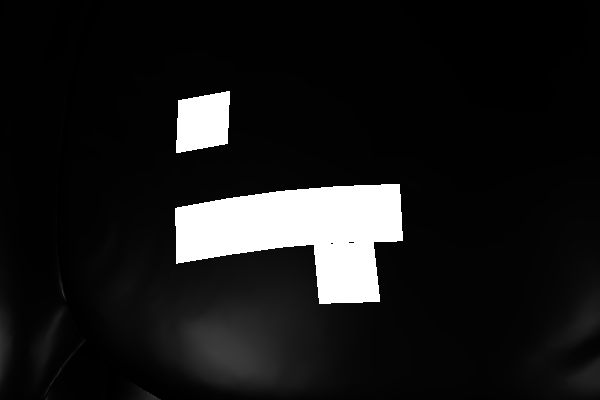

In [316]:
# we'll rotate the camera to a kind of weird angle, but it makes it easier to see the data
urchin.camera.main.set_zoom(2)
urchin.camera.main.set_rotation([-20,-45,0])
await urchin.camera.main.screenshot(size=[600,400])

Good start! Let's get some textures on there.

### Set Texture Images
The images we have are in arbitrary units. Lets rescale them all to have a maximum value of 255, this way we can conveniently send them as uint8 bytes to the renderer, which will save a lot of overhead (sending images is slow!).

In [317]:
# Rescale all of the images to their maximum value, then convert to uint8
datas = [np.uint8(data/np.max(data)*255) for data in datas]

In [318]:
# Send the raw data to the renderer
for i, tex in enumerate(tex_list):
    tex.set_image(datas[i])

In [319]:
urchin.camera.main.set_background_color("#808080")

(Camera receive) Camera CameraMain received an image
(Camera receive) CameraMain complete


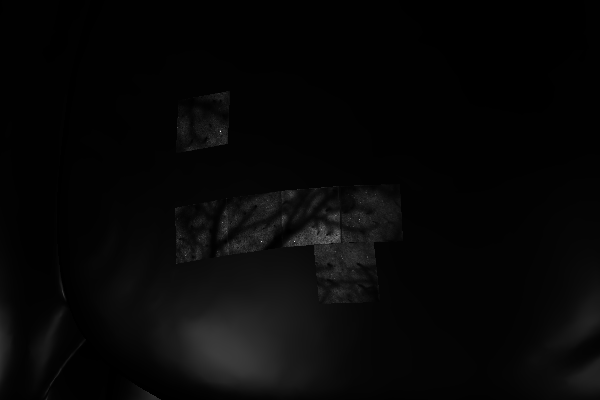

In [320]:
await urchin.camera.main.screenshot(size=[600,400])

### Add individual neurons
Let's overlay the individual neuron estimates from each ROI over the images as well!

In [321]:
# Again we need to download some data
drive_links = [
    "https://drive.google.com/file/d/1beDinFWA0_Ua87A_6STR3y8veV9XejrL/view?usp=drive_link",
    "https://drive.google.com/file/d/1iFPsoubcz_GbJS8jZJzBcvf5i_qFmDXz/view?usp=drive_link",
    "https://drive.google.com/file/d/1Iu7zuWxuDbeVafnKVSxVGeaqH2MkVTAr/view?usp=drive_link",
    "https://drive.google.com/file/d/1whbZdVpaqMPURv3zgx2S-_D0cwhnKhpp/view?usp=drive_link",
    "https://drive.google.com/file/d/1vQlFGM4nJhEjNn0fl5ITfbjTh8Ra-Lwo/view?usp=drive_link",
    "https://drive.google.com/file/d/1jdzPXPs24tcH-f_bIIk0-SGOKVPJvZr6/view?usp=drive_link"
]

class_links = [
    "https://drive.google.com/file/d/1I72Ts9pV6bXg7zi6jTzrW13cELXC704a/view?usp=drive_link",
    "https://drive.google.com/file/d/1upWFdpi78e7rOqop7TK4kk6ozONwtaaU/view?usp=drive_link",
    "https://drive.google.com/file/d/1PbdrdxSg-NCeWPhJ7NxFtpineXwM_UxR/view?usp=drive_link",
    "https://drive.google.com/file/d/19N30xz0cjhpIH3yFqcqXT6LIus5HxBwC/view?usp=drive_link",
    "https://drive.google.com/file/d/1V-8tW03GccjX-UdjIzJzwo0e_QEDdoAf/view?usp=drive_link",
    "https://drive.google.com/file/d/18N9V6eCAU64gRb8FuLCeCUK8fzDNYJFG/view?usp=drive_link"
]

roi_coords = []
for url in drive_links:
    roi_coords.append(download_google_drive_data(url))
    time.sleep(1) # don't query google too fast or they get mad


class_data = []
for url in class_links:
    class_data.append(download_google_drive_data(url))
    time.sleep(1) # don't query google too fast or they get mad

In [322]:
all_coords = []
order = [1, 0, 2] # change order to ap/ml/dv for Urchin

for i, rois in enumerate(roi_coords):
    for j, roi in enumerate(rois):

        if class_data[i][j] > 0:
            pos = [0,0,0]
            for k in np.arange(3):
                pos[k] = directions[k] * roi[order[k]] + bregma[k]

            # add 0.4 on DV to get out of the brain
            pos[2] -= 0.4

            all_coords.append(pos)

In [323]:
neurons = urchin.particles.create(len(all_coords))

In [324]:
urchin.particles.set_positions(neurons, all_coords)
urchin.particles.set_sizes(neurons, [0.015] * len(all_coords))

(Camera receive) Camera CameraMain received an image
(Camera receive) CameraMain complete


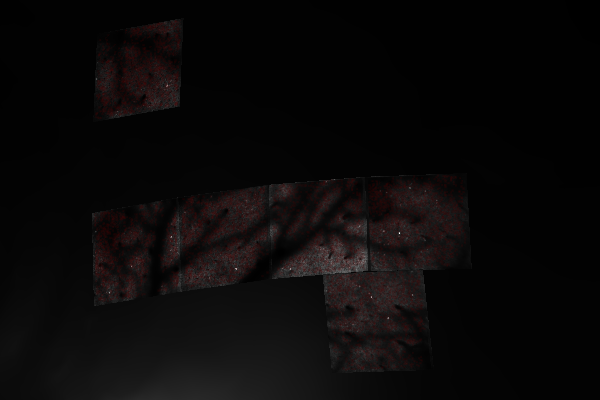

In [325]:
urchin.camera.main.set_zoom(1.2)
await urchin.camera.main.screenshot(size=[600,400])